Импортируем датасет и всё остальное

In [1]:
import torch
from torchvision.datasets import MNIST

In [2]:
import torchvision.transforms as T
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

разделим на train и test

In [3]:
train_set = MNIST(".MNIST", train=True, download=True, transform=T.ToTensor())
test_set = MNIST(".MNIST", train=False, download=True, transform=T.ToTensor())

посмотрим на содержание

In [4]:
for item in train_set:
   break
print(item)

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

Красивенько выведем сами изображения(просто посмотреть)

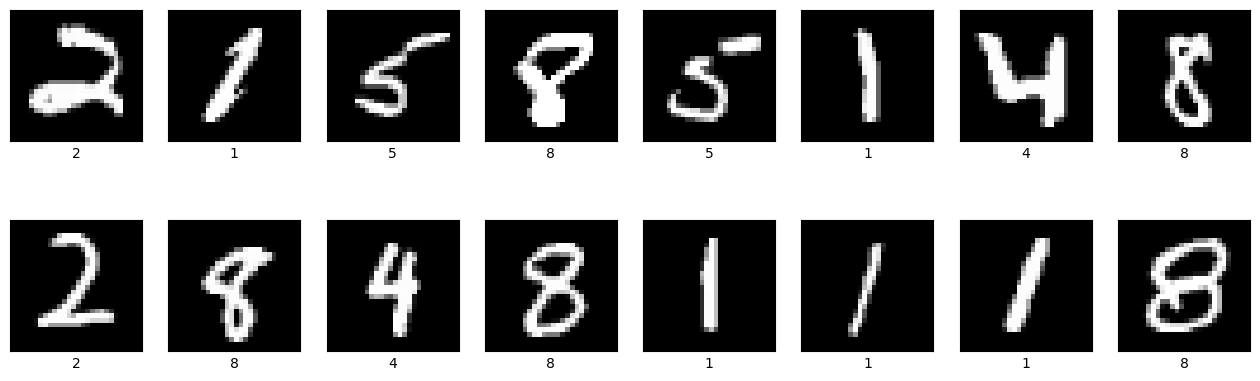

In [5]:
cols = 8
rows = 2
fig = plt.figure(figsize=(cols * 2, rows * 2.5))
for i in range(cols):
    for j in range(rows):
        ran_ind = np.random.randint(0, len(train_set))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(True)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(train_set[ran_ind][0].squeeze(0).numpy().reshape(28, 28), cmap='gray')
        ax.set_xlabel(train_set[ran_ind][1])
plt.show()

загрузим DataLoader

In [29]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, shuffle=True, batch_size=64)
test_loader = DataLoader(test_set, batch_size=1024, shuffle=True)

In [7]:
from torch import nn
import torch.nn.functional as F

Напишем саму сеть

In [39]:
class Net(nn.Module): 
    def __init__(self, in_features, out_features, hide_neurons):
        super(Net, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, hide_neurons),
            nn.ReLU(),
            nn.Linear(hide_neurons, hide_neurons // 2),
            nn.ReLU(),
            nn.Linear(hide_neurons // 2, hide_neurons // 4),
            nn.ReLU(),
            nn.Linear(hide_neurons // 4, out_features)
        )
    def forward(self, X):
        return self.model(X)
    

In [40]:
mod1 = Net(28**2, 10, 64) 
for item in train_loader:
    break
(torch.flatten(item[0], start_dim=1)).shape


torch.Size([64, 784])

Поставим базовые параметры для обучения и лосс функции

In [53]:
img_size = 28
num_classes = 10
hidden_size = 64
num_epochs = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net(img_size ** 2, num_classes, hidden_size).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)

criterion = nn.CrossEntropyLoss()

Теперь обучим модель + добавим статистику

In [54]:

for epoch in range(num_epochs):
    train_loss, train_accuracy = 0, 0
    
    for X_batch, y_batch in train_loader:
        
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        logits = model(torch.flatten(X_batch, start_dim=1))
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        
    if epoch % 2 == 0:
        mean_val_losses = []
        val_accuracy = []
        
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            with torch.no_grad():
                logits = model(torch.flatten(X_batch, start_dim=1))
                loss = criterion(logits, y_batch)
                mean_val_losses.append(loss.item())
                val_accuracy.extend((torch.argmax(logits, dim=-1) == y_batch).numpy().tolist())

        print('Epoch: {epoch}, loss: {loss}, accuracy: {accuracy}'.format(
                epoch=epoch, loss=np.mean(mean_val_losses), accuracy=np.mean(val_accuracy)
        )) 

Epoch: 0, loss: 0.275719541311264, accuracy: 0.916
Epoch: 2, loss: 0.13173889592289925, accuracy: 0.9604
Epoch: 4, loss: 0.12048022970557212, accuracy: 0.9634
Epoch: 6, loss: 0.10436351113021373, accuracy: 0.9678
Epoch: 8, loss: 0.09992848932743073, accuracy: 0.9708
